In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

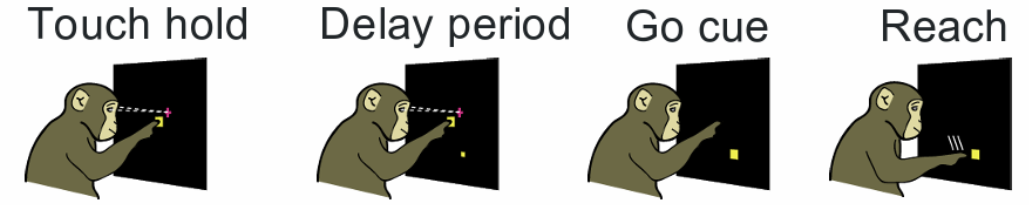

### Lectura de datos, preprocesamiento, y definición de funciones básicas
Nota para el docente: se modificó ligeramente el código base para generar funciones que realicen los pasos básicos para la decodificación, como:
- Extraer las spike counts dentro de una ventana
- Generar los training y testing sets
- Calcular los coeficientes mu de Poisson
- Estimar la verosimilitud para cada target
- Calcular la performance de decodificación

En la celda de SIMULACIÓN BASE, pueden ver cómo quedaron definidas estas funciones, y cómo se aplican. Para más detalle en la implementación, desplegar esta sección del notebook

In [2]:
with open('datos_disparos_mono_tp2.npz', 'rb') as loadfile:
    spike_times = np.load(loadfile, allow_pickle=True)['spike_times'] #shape = 1127 episodios, 190 neuronas, nro de disparos (variable).

with open('metadata_mono_tp2.npy', 'rb') as loadfile:
    metadata = np.load(loadfile)
    time_touch_held = metadata['time_touch_held'] # tiempos de aparición del target para cada episodio
    time_go_cue = metadata['time_go_cue'] # tiempo de señal de GO (comienzo del movimiento) para cada episodio
    time_target_acquired = metadata['time_target_acquired'] # tiempo en que el objetivo fue tocado para cada episodio
    trial_reach_target = metadata['trial_reach_target'] # índice de a que target tenía que ir para cada episodio (0 a 7)
    target_locations = metadata['target_locations'] #  posición x,y de cada target
    target_angles = metadata['target_angles'] # ángulo de cada target


In [3]:
# Notar que hay dos duraciones de periodo de planificación
np.unique(time_go_cue - time_touch_held)

array([ 755, 1005], dtype=int64)

In [4]:
spike_times.shape
spike_times[0][0]

array([549.51355, 595.64166, 669.74585], dtype=float32)

In [5]:
def extract_plan_spikes(window_length=None,
                        start_offset=None,
                        spike_times=spike_times):
    # Devuelve una matriz de conteos de disparos en la ventana de planificación
    # - La ventana de planificación default está definida como el tiempo
    #   entre time_touch_held y time_go_cue para cada episodio.
    #   NOTA: no todos los episodios tienen la misma duración!
    # - Si se especifica una "window_length" (longitud de ventana), devuelve el número
    #   de disparos en la ventana para esa duración. Retorna -1 si el periodo de planificación
    #   es demasiado corto para la ventana (ej. si window_length=1000 pero el periodo de
    #   planificación era 755ms)
    # - Si se especifica un "start_offset", retorna el número de disparos en la ventana
    #   que empieza "start_offset" ms después de time_touch_held (y usa time_go_cue o la
    #   window_length opcional para determinar el final de la ventana). Si start_offset
    #   es tan grande que se extiende más que time_go_cue, retorna -1

    if start_offset:
        trial_starts = time_touch_held + start_offset
    else:
        trial_starts = time_touch_held

    plan_spikes = []
    for tx, trialSpikes in enumerate(spike_times):# Para cada uno de los episodios
        if window_length:
            trial_end = trial_starts[tx] + window_length
        else:
            trial_end = time_go_cue[tx]

        if (trial_end < trial_starts[tx]) or (trial_end > time_go_cue[tx]):
            raise ValueError('''El final del episodio (trial_end) es menor que el comienzo (trial_starts)
                              o que el final del periodo de planificación (time_go_cue)''')
        else:
            plan_spikes.append( # contamos cuantos disparos hubo en esa ventana para cada neurona!
                        np.array(
                        [np.sum((st > trial_starts[tx]) & (st < trial_end)) 
                        for st in trialSpikes] ))
    return np.array(plan_spikes) # debería ser de 1127 x 190 (nro de episodios x nro de neuronas)

Separemos los episodios en set de entrenamiento y testeo

In [6]:
def get_short_trial_sets(short_trial_time, n_of_each, trial_reach_target):
    # creamos un array booleano de longitud 1127 con todos los episodios de duración 755ms en 1 y el resto en 0
    short_trials = (time_go_cue - time_touch_held) == short_trial_time

    training_trials = [] # van a ser 8 listas de episodios (una para cada clase)
    test_trials = [] # todos los que sobran
    for c in range(8): # targets del 0 al 7
        target_trials = np.argwhere(short_trials & (trial_reach_target==c)).squeeze()
        # seleccionar n_of_each episodios al azar (por cada dirección)
        random_training_trials = np.random.choice(target_trials, n_of_each, replace=False)
        training_trials.append(random_training_trials)
        remaining_test_trials = np.setdiff1d(target_trials, random_training_trials)
        # los que sobran, al testing
        test_trials.extend(remaining_test_trials)
    return training_trials, test_trials

In [7]:
# Calcular el nro promedio de disparos por neurona y target
# Representa las medias de una distribución de Poisson 190-dimensional para cada una de las direcciones
def get_mean_spike_counts(training_trials, plan_spikes):
    num_neurons = plan_spikes.shape[1]
    mean_spike_counts = np.zeros((num_neurons, 8)) # Notar que las dimensiones son 190 neuronas x 8 direcciones
    for c in range(8):
        mean_spike_counts[:,c] = np.mean(plan_spikes[training_trials[c],:], axis=0)
    return mean_spike_counts

In [8]:
def multivariate_poisson_logpdf(mu, x, mean_eps=0.01):
    # asume mu es dimensión (N,) y x es (d,N)
    mu2 = mu
    mu2[np.argwhere(mu < mean_eps)] = mean_eps # setea un promedio de disparos muy bajitos para los que daban 0 para evitar que tenga probabilidad 0
    return np.sum(x * np.log(mu2) - mu2, axis=1)

In [9]:
# Calcula la probabilidad para cada target y cada episodio
def get_poisson_likelihood(mean_spike_counts, test_trials, plan_spikes):
    poisson_likelihood = np.zeros((len(test_trials), 8))
    for c in range(8):
        m = mean_spike_counts[:,c]
        poisson_likelihood[:,c] = \
            multivariate_poisson_logpdf(m, plan_spikes[test_trials,:])
    return poisson_likelihood

In [10]:
def decode_targets(test_trials, poisson_likelihood):
    correct_targets = trial_reach_target[test_trials] # target correcto para cada episodio
    decoded_targets = np.argmax(poisson_likelihood,axis=1) # el target decodificado es el que nos dá la mayor verosimilitud!
    return correct_targets, decoded_targets

### SIMULACIÓN BASE, sin window length, sin offset, y usando solo los trials de tiempo corto (755 ms)

In [11]:
# Seleccionar ventanas
plan_spikes = extract_plan_spikes(window_length=None, start_offset=None)
# Armar seleccionar los sets de entrenamiento y testeo al azar
training_trials, test_trials = get_short_trial_sets(755, n_of_each=25, trial_reach_target=trial_reach_target)
# Calcular los disparos medios (mean_spike_counts) usando los datos de entrenamiento
mean_spike_counts = get_mean_spike_counts(training_trials, plan_spikes)
# Calcular las verosimilitudes para cada target
poisson_likelihood = get_poisson_likelihood(mean_spike_counts, test_trials, plan_spikes)
# Decodificar eligiendo cual es el objetivo más probable
correct_targets, decoded_targets = decode_targets(test_trials, poisson_likelihood)

print(f'Porcentaje correcto: {np.mean(correct_targets==decoded_targets):.3f}')
print(f'({len(test_trials)} episodios de testeo)')

Porcentaje correcto: 0.918
(364 episodios de testeo)


---
## Ejercicio 1
#### a) Utilizar una ventana de 750 ms tanto para los episodios largos y cortos
Primero, modificamos la función que separa training de testing para que abarque episodios largos y cortos

In [12]:
def get_trial_sets(n_of_each, trial_reach_target):
    training_trials = [] # van a ser 8 listas de episodios (una para cada clase)
    test_trials = [] # todos los que sobran
    for c in range(8): # targets del 0 al 7
        target_trials = np.argwhere((trial_reach_target==c)).squeeze()
        # seleccionar n_of_each episodios al azar (por cada dirección)
        random_training_trials = np.random.choice(target_trials, n_of_each, replace=False)
        training_trials.append(random_training_trials)
        remaining_test_trials = np.setdiff1d(target_trials, random_training_trials)
        # los que sobran, al testing
        test_trials.extend(remaining_test_trials)
    return training_trials, test_trials

Ajustamos el modelo

In [13]:
# SIMULACIÓN 1A, SIN DELAY, VENTANA DE 750, SIN PARAMETRO TRIAL TIME
plan_spikes = extract_plan_spikes(window_length=750, start_offset=None)
# Seleccionar ventanas
training_trials, test_trials = get_trial_sets(25, trial_reach_target)
# Calcular los disparos medios (mean_spike_counts) usando los datos de entrenamiento
mean_spike_counts = get_mean_spike_counts(training_trials, plan_spikes)
# Calcular las verosimilitudes para cada target
poisson_likelihood = get_poisson_likelihood(mean_spike_counts, test_trials, plan_spikes)
# Decodificar eligiendo cual es el objetivo más probable
correct_targets, decoded_targets = decode_targets(test_trials, poisson_likelihood)
print(f'Porcentaje correcto: {np.mean(correct_targets==decoded_targets):.3f}')
print(f'({len(test_trials)} episodios de testeo)')

Porcentaje correcto: 0.924
(927 episodios de testeo)


La performance disminuyó ligeramente, pero sigue siendo considerablemente alta. Esto nos indica que los resultados que obtuvimos con el training set son representativos a la hora de predecir los casos de testeo

#### b) Rendimiento en función de longitud de la ventana de planificación

Para la siguiente simulacion, y todas las demás que vendrán más adelante, definimos una función que nos permite realizar múltiples tests para cada set de condiciones iniciales, y comparar las distribuciones de sus resultados 

In [14]:
def decode_test_perf(plan_spikes: np.ndarray,
                n_of_each: float) -> float:
    """
    Given the plan spikes and the training test size for each category, perform the decoding algorithm
    and return the percentage accuracy performance

    plan_spikes: matrix (row=realization, col=neuron) with spike counts within the planning stage
    n_of_each: amount of sample realizations to pick from each category when building the training set
    returns: proportion of correct guesses, expressed as a float in [0, 1]
    """
    training_trials, test_trials = get_trial_sets(n_of_each, trial_reach_target)
    mean_spike_counts = get_mean_spike_counts(training_trials, plan_spikes)
    poisson_likelihood = get_poisson_likelihood(mean_spike_counts, test_trials, plan_spikes)
    correct_targets, decoded_targets = decode_targets(test_trials, poisson_likelihood)
    return np.mean(correct_targets==decoded_targets)

In [15]:
def multitest(widths: list[int], 
              offsets: list[int],
              data_subsets: list[np.ndarray],
              list_n_of_each: list[int],
              n_test=50) -> np.ndarray:
    """
    iterates over different initial conditions, tests each one of them multiple times,
    and stores the results in an array of dimensions (len(<initial conditions lists>), n_test)

    widths/offsets: widths/offsets to iterate through
    data_subsets: subsets of spike times to iterate through
    list_n_of_each: training test sizes to iterate through (how many of each direction)
    n_test: number of simulations for every inital condition configuration
    
    return: decode_perf, np.array of shape (len(<initial conditions lists>), n_test) with the performance for each sim
    """
    if not len(widths) == len(offsets) == len(data_subsets):
        raise ValueError('El largo de los parametros no coincide')

    decode_perf = []
    for width, offset, data_subset, n_of_each in zip(widths, offsets, data_subsets, list_n_of_each):
        # Get spike count matrix from specified window
        plan_spikes = extract_plan_spikes(window_length=width, start_offset=offset, spike_times=data_subset)
        decode_perf.append([])

        # Run the decoding algorithm multiple time and store performance
        for i in range(n_test):
            performance = decode_test_perf(plan_spikes, n_of_each)
            decode_perf[-1].append(performance)

    decode_perf = np.array(decode_perf) # convertir a numpy array
    return decode_perf

Creamos una funcion auxiliar para simular variando sólo la ventana, y no la data

In [16]:
def multitest_various_windows(widths: list[int],
                              offsets: list[int], 
                              data_subset: np.ndarray=spike_times,
                              n_of_each: int=25,
                              n_test: int=50) -> np.ndarray:
    """
    multitest changing only the window, but using the same data every time
    (which is, by default, the full-lenght spike_time global variable)
    """
    data_subsets = [data_subset]*len(widths)
    list_n_of_each = [n_of_each]*len(widths)
    return multitest(widths, offsets, data_subsets, list_n_of_each, n_test)

Ya tenemos definidas las funciones para realizar múltiples tests sobre distintas condiciones iniciales. Ahora, vamos a iterar sobre distintos anchos de ventana, desde 50 hasta 750 ms

In [17]:
anchos_ventana = np.arange(50, 750, 50)
offsets = [None]*len(anchos_ventana)
decode_perf_anchos = multitest_various_windows(anchos_ventana, offsets, n_test=50)

Ahora, ploteamos los resultados usando pandas y seaborn

In [18]:
def plot_multitest(decode_perf: np.ndarray, **kwargs) -> tuple[plt.figure, plt.axis]:
    """
    Draws an aesthetically pleasing violin plot, as suggested by Ing. Kienigiel
    """
    fig = plt.figure(figsize=(12, 8))
    ax = sns.violinplot(data=pd.DataFrame(decode_perf.T))
    ax.set(ylabel='Precisión decodificando', xticks=np.arange(len(decode_perf)))
    ax.set(**kwargs)
    plt.show()
    return fig, ax

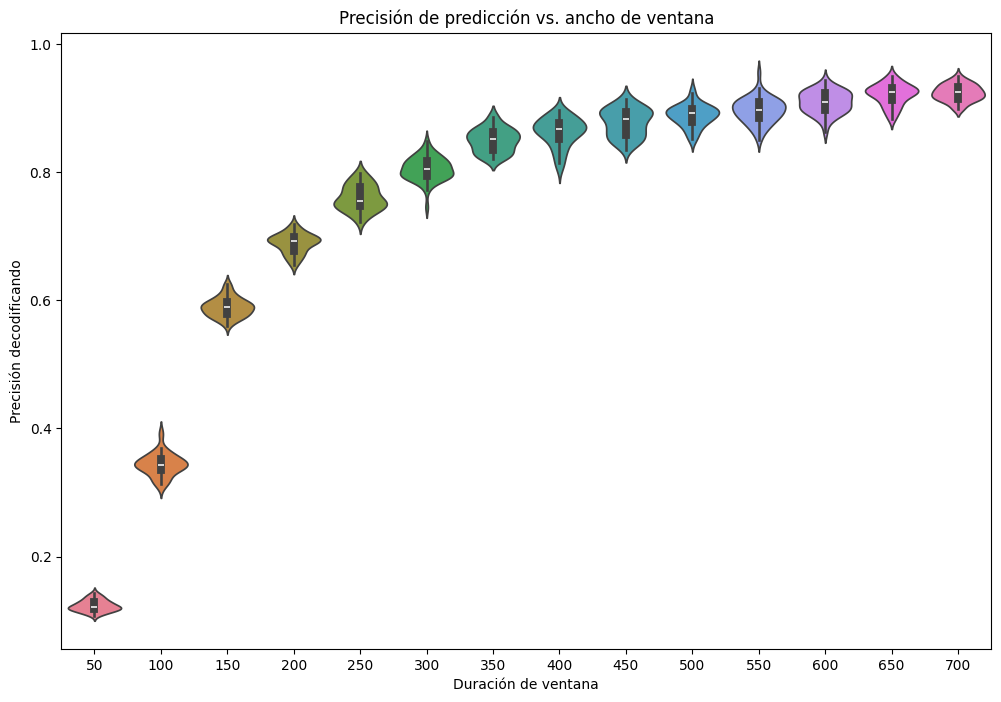

In [19]:
plot_multitest(decode_perf_anchos,
               title='Precisión de predicción vs. ancho de ventana',
               xlabel='Duración de ventana',
               xticklabels = anchos_ventana); #el ; final es para que jupyter no imprima los return values

En principio, con ventanas mayores a 500 ms se empiezan a obtener resultados con precisión mayor al 90%

### c) Análisis de la injerencia del offset


In [20]:
offsets = np.arange(0, 500, 50)
widths = [250]*len(offsets)
decode_perf_offsets = multitest_various_windows(widths, offsets, n_test=50)

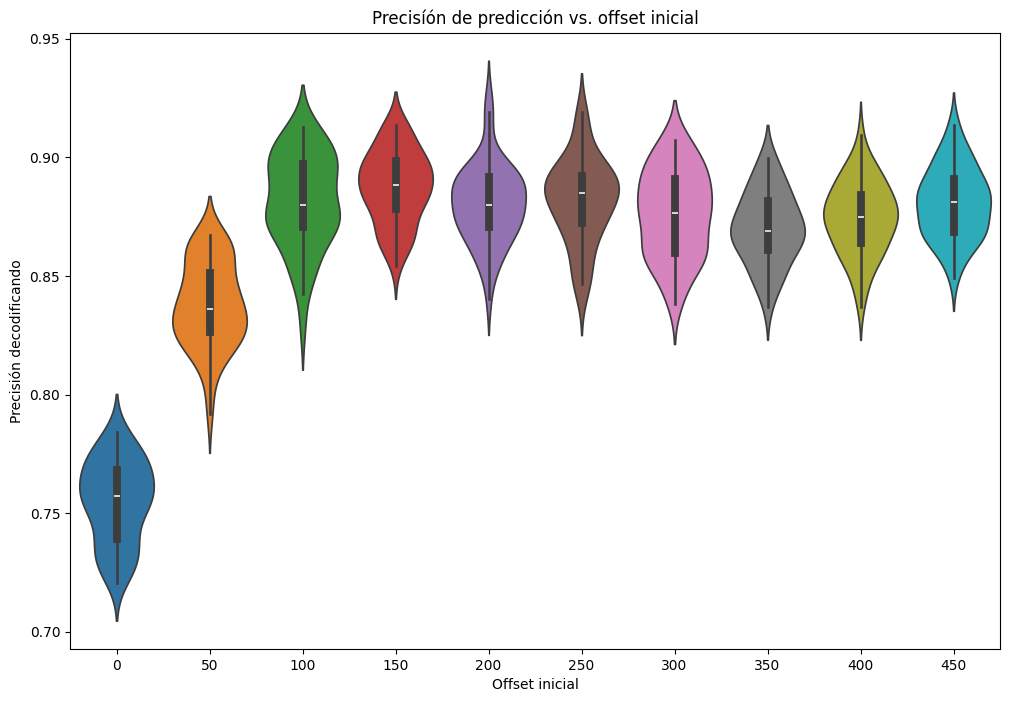

In [21]:
plot_multitest(decode_perf_offsets,
               title='Precisíón de predicción vs. offset inicial',
               xlabel='Offset inicial',
               xticklabels=offsets);

Podemos inferir que el momento clave ocurre entre los 50 y los 100 ms

## Ejercicio 2
#### a) ¿Cómo afecta el rendimiento la cantidad de neuronas que puedo medir?
Primero, creamos la función para seleccionar neuronas, y obtener así un subset de la matriz de spikes

In [22]:
def get_reduced_spike_times(n_neurons: int, spike_times=spike_times):
    """
    n_neurons: amount of neurons to keep

    returns: a reduced version of spike times with only 'n_neurons' columns
    """
    og_idxs = np.arange(spike_times.shape[1])
    new_idxs = np.random.choice(og_idxs, n_neurons, replace=False)
    return spike_times[:, new_idxs]

In [23]:
red_spike_times = get_reduced_spike_times(10, spike_times)
red_spike_times.shape

(1127, 10)

Luego, modificamos nuestra función de multitest para que trabaje con distintos subsets de los datos originales (menos neuronas)...

In [24]:
def multitest_various_subsets(width: int, 
                              offset: int, 
                              spike_times_list: list[np.ndarray],
                              n_of_each: int=25, 
                              n_test: int=50) -> np.ndarray:
    """
    multitest changing only the data subsets, but using the same window
    """
    widths = [width]*len(spike_times_list)
    offsets = [offset]*len(spike_times_list)
    list_n_of_each = [n_of_each]*len(spike_times_list)
    return multitest(widths, offsets, spike_times_list, list_n_of_each, n_test)

... y a partir de esta función, definimos una que itere sobre distintas cantidades de neuronas

In [25]:
def multitest_various_ncounts(width: int, 
                              offset: int, 
                              neuron_counts: list[int], 
                              n_test: int=50) -> np.ndarray:
    """
    multitest using randomly different lenght sets of randomly selected neurons
    """
    spike_times_list = []
    for n_neurons in neuron_counts:
        # Reduce the spike time matrix to n random neurons
        red_spike_times = get_reduced_spike_times(n_neurons, spike_times)
        spike_times_list.append(red_spike_times)

    return multitest_various_subsets(width, offset, spike_times_list, n_test=n_test)    

Evaluamos los resultados para [30, 60, 90, 120, 150] neuronas

In [26]:
n_counts = [30, 60, 90, 120, 150]
perf_n_counts = multitest_various_ncounts(250, 100, neuron_counts=n_counts, n_test=50)

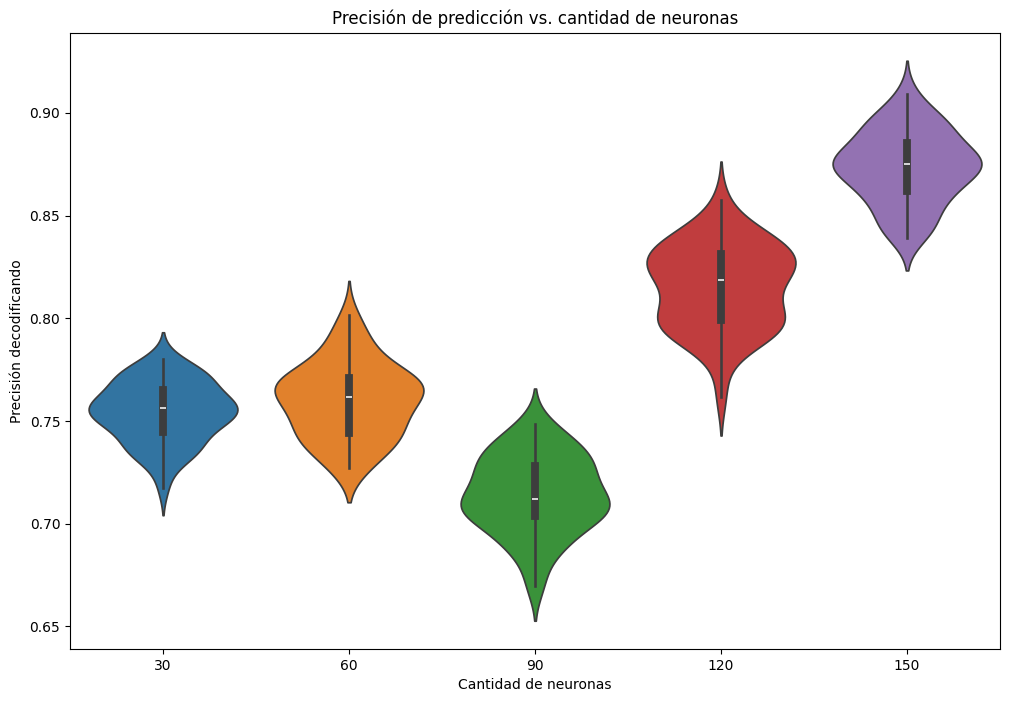

In [27]:
plot_multitest(perf_n_counts, 
               xlabel='Cantidad de neuronas', 
               title='Precisión de predicción vs. cantidad de neuronas', 
               xticklabels=n_counts);

Aparentemente, a partir de entre 60 y 90 neuronas escogidas al azar tenemos una buena capacidad de predicción.

#### b) ¿Cómo afecta el rendimiento tomar...?
- Las 30 neuronas más activas
- Las 30 neuronas menos activas
- 30 neuronas al azar

Para las 30 neuronas random, utilizamos la función previamente definida

In [28]:
rand_30_spike_times = get_reduced_spike_times(30, spike_times)
rand_30_spike_times.shape

(1127, 30)


Para seleccionar las 30 neuronas más/menos activas en promedio, ordenamos la matriz de spike times por la media de sus columnas, y nos quedamos con las primeras 30 de ellas

In [29]:
def sort_by_mean(X: np.ndarray) -> np.ndarray:
    """
    X: generic 3D numpy array (2D matrix where each cell is a 1D array)

    returns a version of X sorted by its row average for each column
    (calculated after counting the lenght of each cell array)
    """
    X_copy = X.copy()
    X_mean = np.zeros((X_copy.shape))
    for i in range(X_copy.shape[0]):     # recordemos que cada X[i, j] es un array de por si!
        for j in range(X_copy.shape[1]):
            X_copy[i, j] = len(X[i, j])   # para cada celda, guardamos su longitud
    X_mean = X_copy.mean(axis=0)
    col_indeces = X_mean.argsort()
    return X[:, col_indeces]

In [30]:
spike_times_sorted = sort_by_mean(spike_times)
top_30_spike_times = spike_times_sorted[:, -30:]
bot_30_spike_times = spike_times_sorted[:, :30]
top_30_spike_times.shape

(1127, 30)

Nuevamente, utlizamos la funcion de multitest para iterar sobre estos subsets

In [31]:
spike_times_list = [top_30_spike_times, bot_30_spike_times, rand_30_spike_times]
perf_TBR = multitest_various_subsets(250, 100, spike_times_list, n_test=25)

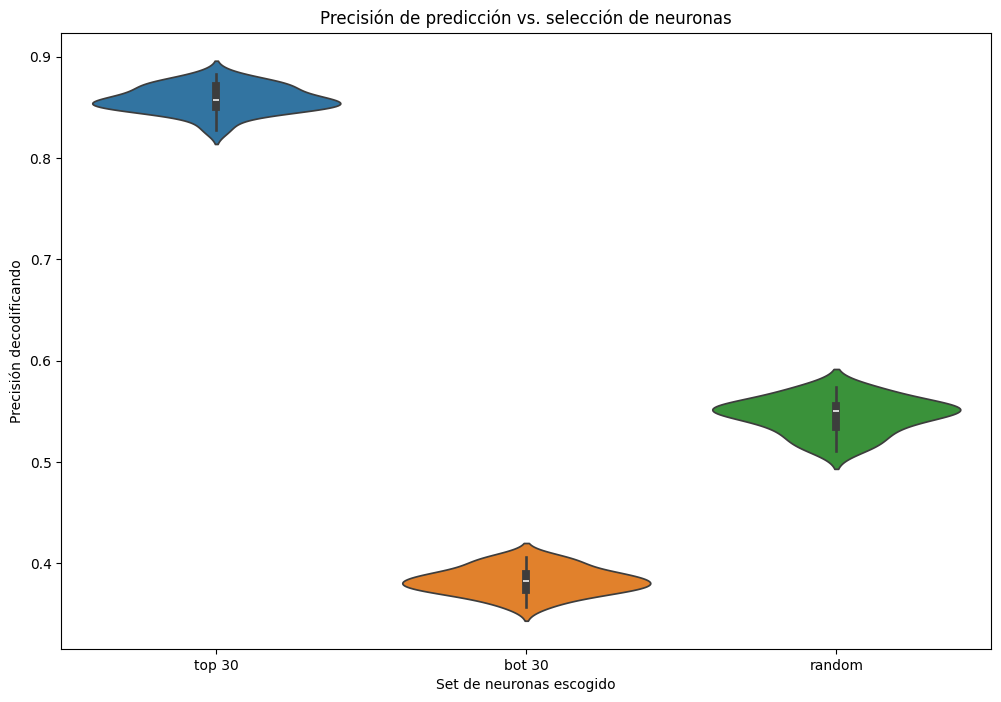

In [32]:
plot_multitest(perf_TBR, 
               xlabel='Set de neuronas escogido', 
               xticklabels=['top 30', 'bot 30', 'random'], 
               title='Precisión de predicción vs. selección de neuronas');

Es notable cómo las neuronas con mayor activación permiten predecir con mayor fidelidad la activación

Para evaluar es mayor detalle cómo varían los resultados para distintas selecciones de neuronas aleatorias, vamos a realizar múltiples experimentos de muestro aleatorio 

In [33]:
rand_30_list = []
for i in range(10):
    new_rand_30 = get_reduced_spike_times(30, spike_times)
    rand_30_list.append(new_rand_30)
perf_random = multitest_various_subsets(250, 100, rand_30_list, n_test=25)

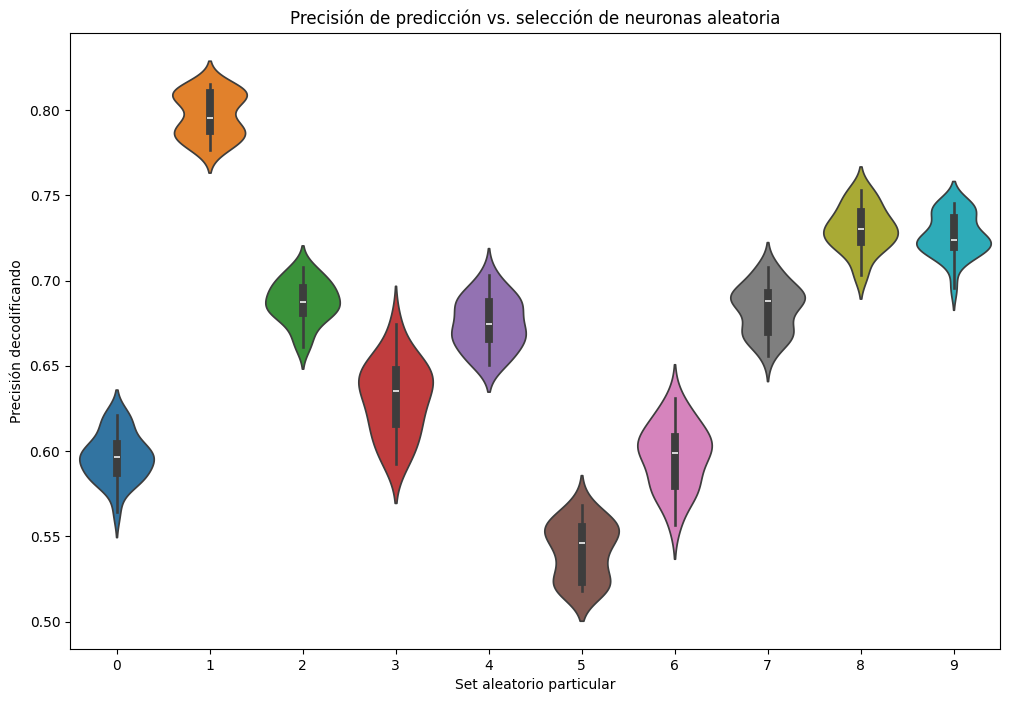

In [34]:
plot_multitest(perf_random, 
               xlabel='Set aleatorio particular', 
               title='Precisión de predicción vs. selección de neuronas aleatoria');

Como podemos observar, si bien la dispersión es amplia, la media de los resultados es inferior al 70% aproximadamente

#### Bonus: mínimo de neuronas que dan un buen rendimiento
Para este ejercicio, sabiendo que las neuronas de mayor activación dan mejores resultados en promedio, vamos a realizar una búsqueda binaria sobre el número idóneo de neuronas a escoger del set de neuronas ordenadas por orden de activación. En particular, vamos a buscar la cantidad de neuronas que nos dé una performance promedio del 80% simulando con 50 realizaciones por elección, y con un training set de 25 episodios por categoría

In [35]:
N_neurons = spike_times.shape[1]
low = 0
upp = N_neurons
mid = (low + upp)//2
n_count_list = [mid]
desired_perf = 0.8

while upp - low > 1:
    data_subset = spike_times_sorted[:, -mid:]
    perf_subest = multitest_various_subsets(250, 100, [data_subset], n_test=50) # we use only one subset at a time!
    avg_perf = perf_subest.mean()
    if avg_perf > desired_perf:
        upp = mid
    else:
        low = mid
    print(f"{mid=}, {avg_perf=:.3f}")
    n_count_list.append(mid)
    mid = (low + upp)//2

print()
print(f"Cantidad óptima: {mid}")

mid=95, avg_perf=0.840
mid=47, avg_perf=0.846
mid=23, avg_perf=0.866
mid=11, avg_perf=0.753
mid=17, avg_perf=0.809
mid=14, avg_perf=0.811
mid=12, avg_perf=0.753
mid=13, avg_perf=0.810

Cantidad óptima: 12


Para mostrar la convergencia del algoritmo, vamos a plotear los violines de cada iteración

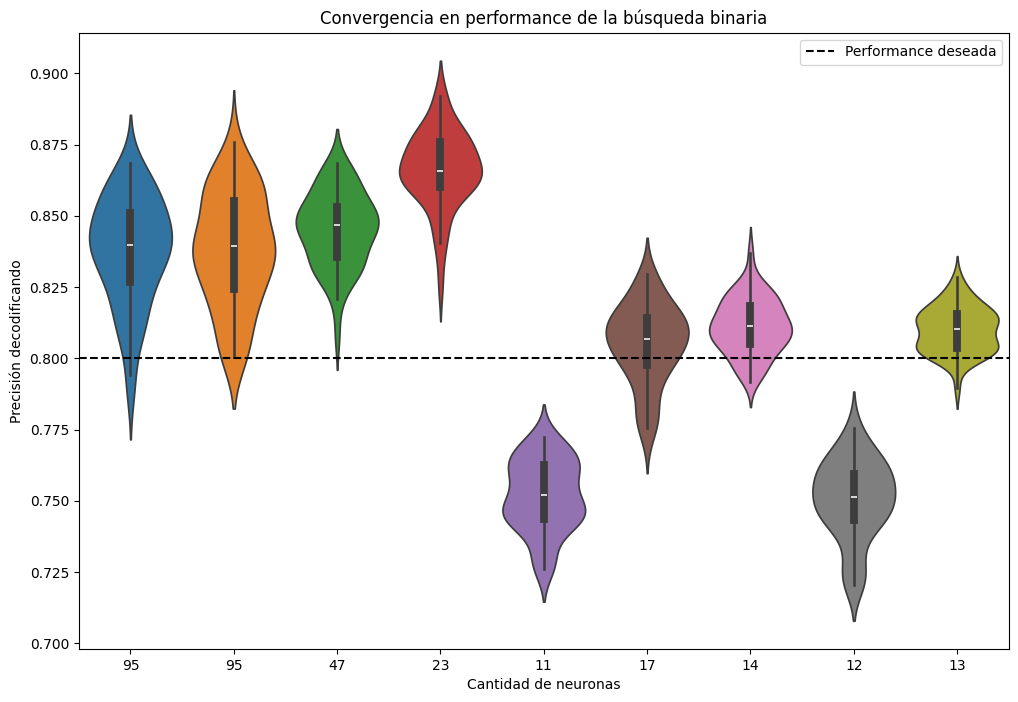

In [38]:
subsets = []
for n in n_count_list:
    subsets.append(spike_times_sorted[:, -n:])

perf_binary_search = multitest_various_subsets(250, 100, subsets, n_test=50)

fig = plt.figure(figsize=(12, 8))
ax = sns.violinplot(data=pd.DataFrame(perf_binary_search.T))
ax.set(ylabel='Precisión decodificando', xticks=np.arange(len(n_count_list)))
ax.set(title="Convergencia en performance de la búsqueda binaria",
       xlabel="Cantidad de neuronas",
       xticklabels=n_count_list)
ax.axhline(0.8, linestyle='--', color='k', label='Performance deseada')
plt.legend()
plt.show()

## Ejercicio 3
#### a) ¿Cómo afecta el rendimiento la cantidad de datos de entrenamiento?
Nuevamente, definimos una nueva función de multitest que itere sobre distintas condiciones de simulación

In [39]:
def multitest_various_training_sizes(width: int, 
                                     offset: int, 
                                     training_test_sizes: list[int], 
                                     n_test: int=50) -> np.ndarray:
    """
    misma idea que antes, pero ahora variamos solo los training_test_sizes
    """
    widths = [width]*len(training_test_sizes)
    offsets = [offset]*len(training_test_sizes)
    data_subsets = [spike_times]*len(training_test_sizes)
    return multitest(widths, offsets, data_subsets, training_test_sizes, n_test)

Finalmente, lo testeamos para [5, 10, 15, 20, 25, 30, 35, 40] muestras de cada target

In [40]:
training_test_sizes = [5, 10, 15, 20, 25, 30, 35, 40]
perf_train_size = multitest_various_training_sizes(250, 100, training_test_sizes, n_test=25)

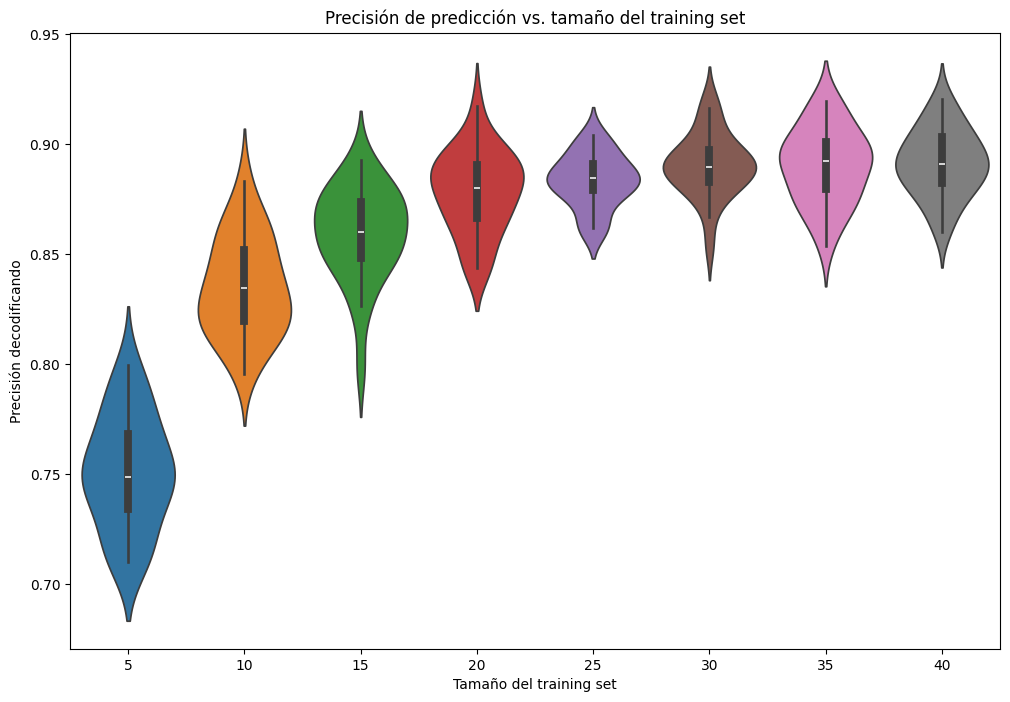

In [41]:
plot_multitest(perf_train_size, 
               xlabel='Tamaño del training set', 
               title='Precisión de predicción vs. tamaño del training set', 
               xticklabels=training_test_sizes)
plt.show()

Con un training set de entre 20 y 25 muestras por dirección pareciera ser suficiente para obtener resultados fiables.